In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

ROOT_DIR = '/gscratch/ubicomp/hughsun/HAM10000/ResNet'

In [7]:
import numpy as np
import pandas as pd

In [3]:
device = 'cuda'
model = torchvision.models.resnet50(pretrained=True).to(device)
model.fc = nn.Linear(2048, 7).to(device)
model.load_state_dict(torch.load(f'{ROOT_DIR}/skin_models/skinmodel50.pt'))

<All keys matched successfully>

# create custom data loader

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
from PIL import Image

In [10]:
data = pd.read_csv(f'{ROOT_DIR}/HAM10000_metadata.csv')

In [11]:
file = data.iloc[0]['image_id'] + '.jpg'

In [12]:
data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [13]:
class SkinDataset(Dataset):
    
    def __init__(self, transform):
        data = pd.read_csv(f'{ROOT_DIR}/HAM10000_metadata.csv')
        self.metadata = data
        self.transform = transform
        
    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img = self.read_image(idx)
        tensor_img = self.transform(img)
        age = self.metadata.iloc[idx]['age']
        sex = self.metadata.iloc[idx]['sex']
        return (tensor_img, age, sex)
        
    def read_image(self, idx):
        image_file_name = self.metadata.iloc[idx]['image_id']
        return Image.open(f'{ROOT_DIR}/HAM10000/{image_file_name}.jpg')

In [14]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [15]:
skindataset = SkinDataset(val_transforms)

In [16]:
data_loader = torch.utils.data.DataLoader(
    skindataset, batch_size=64, shuffle=False,
    pin_memory=True, drop_last=False)

# extract embeddings from neural net

In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
def get_features(list_of_results):
    '''
    A hook function that grabs the output of a neural net intermediate layer.
    '''
    def hook(model, input, output):
        list_of_results.append(output.detach().cpu().numpy())
    return hook

In [19]:
embedding = []
ages = []
sexes = []

In [20]:
model.avgpool.register_forward_hook(get_features(embedding))

In [21]:
num_classes = 7

model.eval()

with torch.no_grad():
    for inputs, age, sex in data_loader:        
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        ages.append(age)
        sexes.append(sex)

In [22]:
embedding = np.concatenate(embedding)

In [23]:
embedding.shape

(10015, 2048, 1, 1)

In [24]:
embedding = embedding.reshape(-1, 2048)

In [25]:
embedding.shape

(10015, 2048)

In [27]:
ages[0]

tensor([80., 80., 80., 80., 75., 75., 60., 60., 70., 70., 55., 85., 85., 70.,
        70., 65., 75., 75., 70., 70., 70., 60., 60., 75., 75., 40., 40., 40.,
        40., 70., 70., 60., 60., 80., 80., 85., 85., 85., 85., 85., 85., 60.,
        60., 50., 50., 50., 75., 75., 40., 40., 80., 75., 75., 45., 45., 70.,
        75., 75., 60., 50., 75., 75., 75., 75.], dtype=torch.float64)

In [28]:
ages = np.concatenate(ages)

In [29]:
ages.shape

(10015,)

In [36]:
sexes[0]

('male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'female',
 'female',
 'female',
 'female',
 'female',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'female',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'female',
 'female',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'female',
 'female',
 'male',
 'male',
 'female',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'female',
 'female',
 'female',
 'female')

In [37]:
sexes = np.concatenate(sexes)

In [38]:
sexes.shape

(10015,)

# TSNE visualization of embedding

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
tsne = TSNE(n_components=2, random_state=0)
tsne_array = tsne.fit_transform(embedding)

/gscratch/ubicomp/hughsun/conda/HAM10000_resnet/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/gscratch/ubicomp/hughsun/conda/HAM10000_resnet/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [51]:
tsne_df = pd.DataFrame(data=tsne_array, columns=["x", "y"])

In [53]:
tsne_df.head()

x          y
0 -24.812563  57.457912
1 -13.563281  51.165726
2  -9.493519  60.545204
3  -3.289319  52.000687
4 -32.114128  60.964016

In [54]:
tsne_df['sex'] = sexes

In [55]:
tsne_df['age'] = ages

In [56]:
tsne_df.head()

x          y   sex   age
0 -24.812563  57.457912  male  80.0
1 -13.563281  51.165726  male  80.0
2  -9.493519  60.545204  male  80.0
3  -3.289319  52.000687  male  80.0
4 -32.114128  60.964016  male  75.0

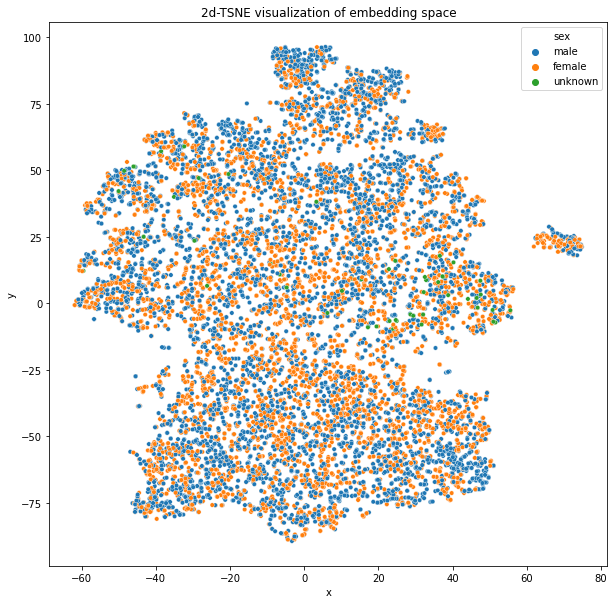

In [70]:
plt.figure(figsize = (10, 10))
sns.scatterplot(x='x', y='y', data=tsne_df, hue='sex', s = 20)
plt.title('2d-TSNE visualization of embedding space')
plt.show()

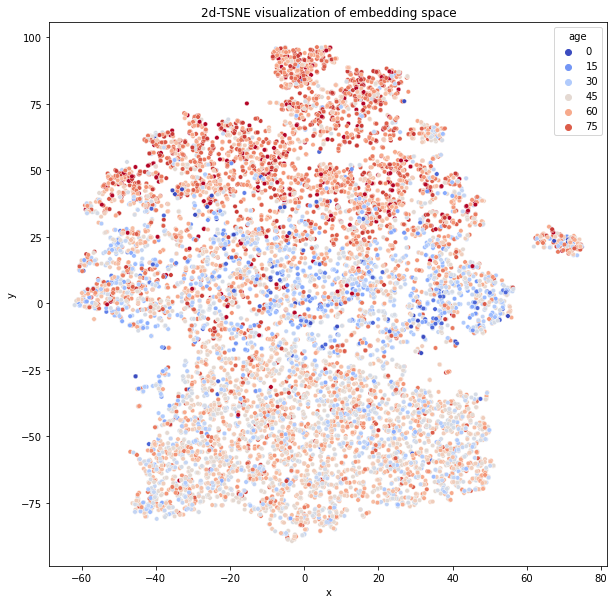

In [85]:
plt.figure(figsize = (10, 10))
sns.scatterplot(x='x', y='y', data=tsne_df, hue='age', s = 20, palette=sns.color_palette("coolwarm", as_cmap=True))
plt.title('2d-TSNE visualization of embedding space')
plt.show()

<ipython-input-89-5d04e7a20c75>:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(sm)


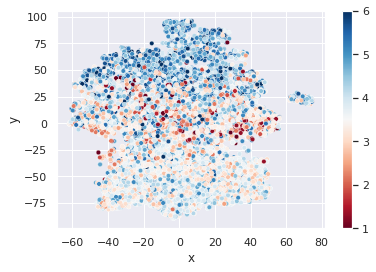

In [89]:
sns.set()
# tips = sns.load_dataset("tips")
# ax = sns.scatterplot(x="total_bill", y="tip", hue="size", palette='RdBu', data=tips)
ax = sns.scatterplot(x='x', y='y', data=tsne_df, hue='age', s = 20, palette=sns.color_palette("RdBu", as_cmap=True))


norm = plt.Normalize(tips['size'].min(), tips['size'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

## TSNE in 3 dimensions

In [90]:
tsne = TSNE(n_components=3, random_state=0)
tsne_array = tsne.fit_transform(embedding)

tsne_df = pd.DataFrame(data=tsne_array, columns=["x", "y", "z"])

tsne_df['sex'] = sexes

tsne_df['age'] = ages

/gscratch/ubicomp/hughsun/conda/HAM10000_resnet/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/gscratch/ubicomp/hughsun/conda/HAM10000_resnet/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [104]:
import plotly.express as px

In [105]:
fig = px.scatter_3d(tsne_df, x='x', y='y', z='z',
                    color='sex')
fig.show()

In [106]:
fig = px.scatter_3d(tsne_df, x='x', y='y', z='z',
                    color='age')
fig.show()